## PART 1

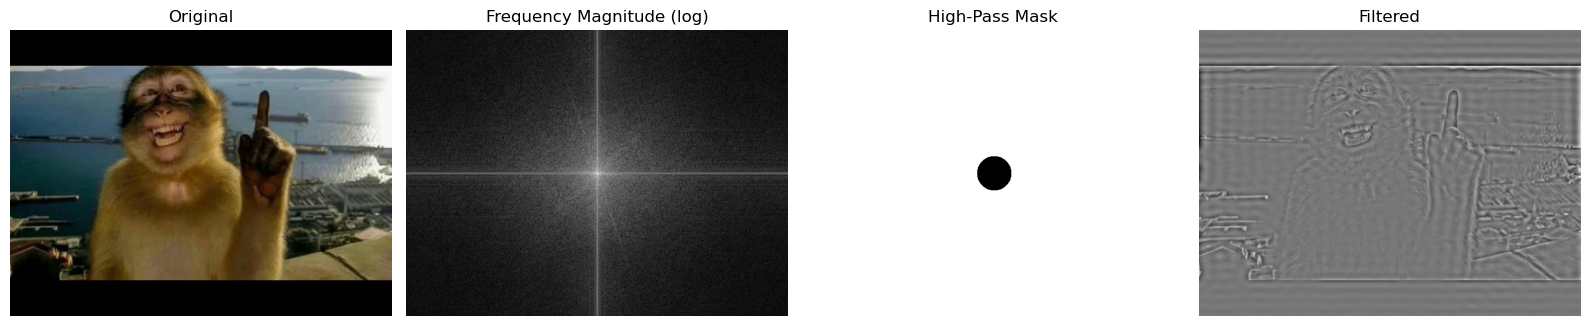

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def high_pass_fft(img, cutoff):
    img = np.asarray(img, dtype=float)

    img = img[..., :3].mean(axis=2)

    # Normalize for stable numbers
    img_norm = (img - img.min()) / (img.max() - img.min())

    h, w = img_norm.shape

    # FFT + shift
    F = np.fft.fft2(img_norm)
    Fshift = np.fft.fftshift(F)

    # Magnitude spectrum for visualization
    magnitude_spectrum = np.log(1 + np.abs(Fshift))

    cy, cx = h // 2, w // 2
    Y, X = np.ogrid[:h, :w]
    dist = np.sqrt((Y - cy)**2 + (X - cx)**2)

    radius = cutoff * min(h, w) / 2.0 if 0 < cutoff <= 1 else float(cutoff)
    mask = (dist >= radius).astype(float)

    Fshift_filtered = Fshift * mask

    # Inverse FFT
    F_ishift = np.fft.ifftshift(Fshift_filtered)
    filtered = np.fft.ifft2(F_ishift)
    filtered = np.real(filtered)

    # Normalize output
    filtered -= filtered.min()
    filtered /= filtered.max() if filtered.max() != 0 else 1

    return filtered, mask, magnitude_spectrum


img = mpimg.imread("image.png")

cutoff = 0.12
filtered, mask, magnitude = high_pass_fft(img, cutoff)

plt.imsave("original.png", img, cmap='gray')
plt.imsave("frequency_magnitude.png", magnitude, cmap='gray')
plt.imsave("highpass_mask.png", mask, cmap='gray')
plt.imsave("filtered.png", filtered, cmap='gray')


fig = plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(magnitude, cmap='gray')
plt.title("Frequency Magnitude (log)")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(mask, cmap='gray')
plt.title("High-Pass Mask")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(filtered, cmap='gray')
plt.title("Filtered")
plt.axis("off")

fig.tight_layout()
fig.savefig("combined_plot.png", dpi=300)

plt.show()


## Part 1 — High-Pass Filtering via FFT

In this part, we implement a high-pass filtering pipeline in the frequency domain.

1. **Normalize the image**
   - FFT calculations work best when values are in a consistent range (0–1).

2. **Compute the 2D discrete Fourier transform**
   - We use `np.fft.fft2` to obtain the frequency spectrum.
   - The zero-frequency component is moved to the center using `fftshift`, which makes analysis easier.

3. **Construct a radial high-pass mask**
   - Low frequencies lie near the center of the spectrum.
   - By defining a cutoff radius, we keep only high-frequency components (edges).

4. **Apply the mask in frequency space**
   - This removes low-frequency information (smooth intensity variations).

5. **Perform the inverse FFT**
   - After masking, we transform the filtered spectrum back to the spatial domain.
   - The result highlights edges and fine details.

### What We Observe
- The **magnitude spectrum** shows strong energy in the center (low frequencies dominate).
- The **filtered image** emphasizes sharp transitions, acting like an edge detector.

## PART 2

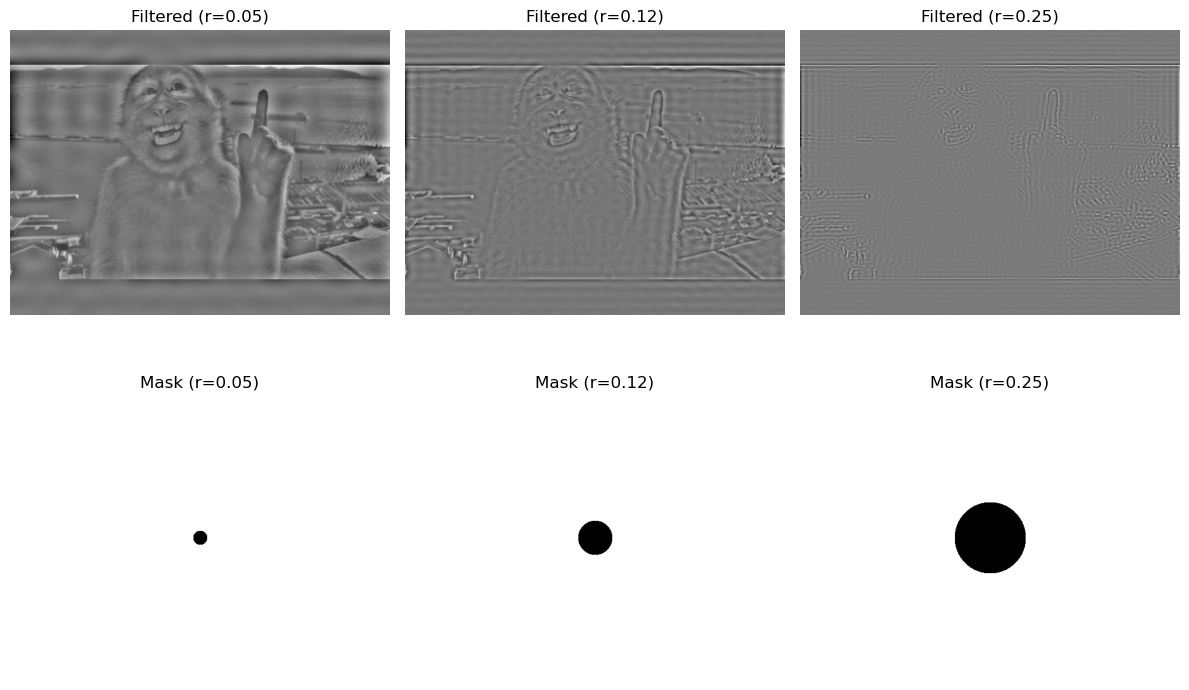

In [3]:

img = mpimg.imread("image.png")

# Safety Check 
if img.ndim == 3:
    img_gray = img[..., :3].mean(axis=2)
else:
    img_gray = img

cutoff_values = [0.05, 0.12, 0.25]   # Small, Medium, Large
results = []

for cutoff in cutoff_values:
    
    filtered, mask, _ = high_pass_fft(img, cutoff) 
    results.append((cutoff, filtered, mask))
    plt.imsave(f"filtered_cutoff_{cutoff}.png", filtered, cmap='gray')

# Visualization
fig = plt.figure(figsize=(12, 8))

for idx, (cutoff, filtered, mask) in enumerate(results):
   
    plt.subplot(2, len(results), idx + 1)
    plt.imshow(filtered, cmap='gray')
    plt.title(f"Filtered (r={cutoff})")
    plt.axis("off")

    plt.subplot(2, len(results), idx + 1 + len(results))
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask (r={cutoff})")
    plt.axis("off")

plt.tight_layout()
plt.savefig("comparison_multiple_cutoffs.png", dpi=300)
plt.show()

## Part 2 — Effect of Different Cutoff Radii

In this part, we apply the high-pass filter with three different cutoff values:

- **0.05** (small radius)
- **0.12** (medium radius)
- **0.25** (large radius)

The cutoff radius determines how much of the low-frequency content is removed.
A small radius removes only the very center of the spectrum, while a large radius blocks a much larger region.

- Too small → edges are weak  
- Too large → image becomes noisy  
- Mid-range → best balance  

#### **Cutoff = 0.05**
- Only the very lowest frequencies are removed.
- The filtered image looks soft.
- Edge response is weak but clean (little noise).

#### **Cutoff = 0.12**
- More low-frequency energy removed.
- Edges become clearer and sharper.

#### **Cutoff = 0.25**
- A large portion of the spectrum is suppressed.
- Only very high frequencies remain.
- Edges are extremely sharp but the image becomes noisy.

## PART 3

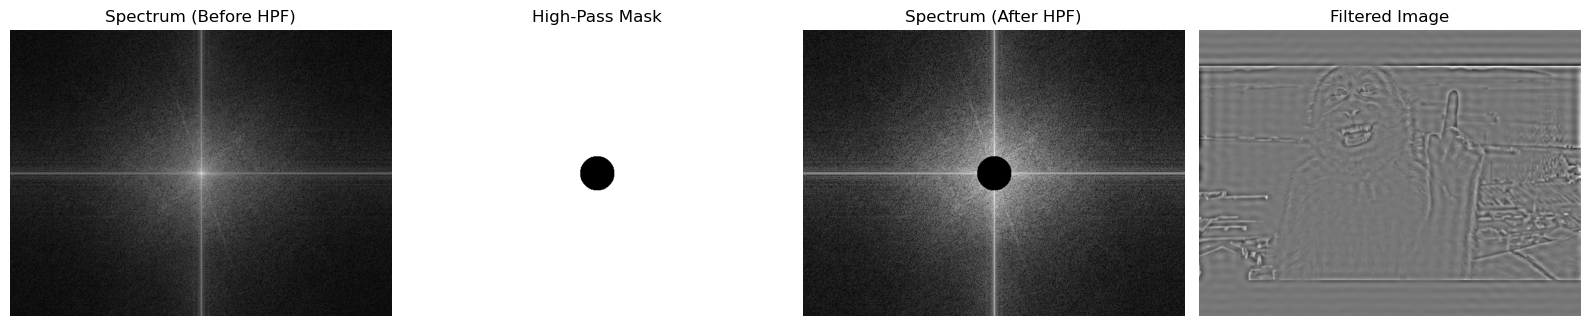

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def high_pass_fft_with_spectrum(img, cutoff):
    img = np.asarray(img, dtype=float)

    img = img[..., :3].mean(axis=2)

    img_norm = (img - img.min()) / (img.max() - img.min())

    h, w = img_norm.shape

    # FFT + shift
    F = np.fft.fft2(img_norm)
    Fshift = np.fft.fftshift(F)

    # Magnitude BEFORE filtering
    spectrum_before = np.log(1 + np.abs(Fshift))

    # HPF mask
    cy, cx = h // 2, w // 2
    Y, X = np.ogrid[:h, :w]
    dist = np.sqrt((Y - cy)**2 + (X - cx)**2)
    radius = cutoff * min(h, w) / 2.0
    mask = (dist >= radius).astype(float)

    # Apply mask
    Fshift_filtered = Fshift * mask

    # Magnitude AFTER filtering
    spectrum_after = np.log(1 + np.abs(Fshift_filtered))

    # Inverse FFT
    F_ishift = np.fft.ifftshift(Fshift_filtered)
    filtered = np.real(np.fft.ifft2(F_ishift))

    # Normalize
    filtered -= filtered.min()
    filtered /= filtered.max() if filtered.max() != 0 else 1

    return filtered, mask, spectrum_before, spectrum_after


img = mpimg.imread("image.png")

# Set cutoff radius
cutoff = 0.12

# Apply HPF and get spectra
filtered, mask, spectrum_before, spectrum_after = high_pass_fft_with_spectrum(img, cutoff)

plt.imsave("spectrum_before.png", spectrum_before, cmap='gray')
plt.imsave("spectrum_after.png", spectrum_after, cmap='gray')
plt.imsave("hpf_mask.png", mask, cmap='gray')
plt.imsave("filtered_hpf.png", filtered, cmap='gray')

fig = plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.imshow(spectrum_before, cmap='gray')
plt.title("Spectrum (Before HPF)")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(mask, cmap='gray')
plt.title("High-Pass Mask")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(spectrum_after, cmap='gray')
plt.title("Spectrum (After HPF)")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(filtered, cmap='gray')
plt.title("Filtered Image")
plt.axis("off")

fig.tight_layout()
fig.savefig("frequency_analysis.png", dpi=300)

plt.show()


## Part 3 — Frequency Spectrum Visualization

### Steps Performed
1. Compute the centered Fourier transform of the original image.
2. Take the log-magnitude spectrum for visualization.
3. Apply the high-pass mask.
4. Compute the log-magnitude spectrum again, this time of the filtered frequency data.

### Visualize the Spectrum
The Fourier magnitude plot reveals:
- Where the energy of the image is concentrated.
- How much information the filter removes.
- How high-pass filtering redistributes frequency content.

### Observations
#### **Spectrum Before Filtering**
- Very bright center (low frequencies dominate).
- Outer regions are darker (high frequencies have less energy).

#### **High-Pass Mask**
- A dark circular region blocks the low frequencies.
- White outer regions indicate passing high-frequency components.

#### **Spectrum After Filtering**
- The center becomes dark (removed frequencies).
- Only the outer high-frequency ring remains.

#### **Filtered Image**
- Contains mostly edges and fine details since low frequencies were suppressed.



## bonus part

In [1]:
import numpy as np
import matplotlib.image as mpimg

def binarize(img, fixed_threshold=0.2):
    img = img.astype(float)

    if img.ndim == 3:
        img = img[..., :3].mean(axis=2)

    # Normalize 0-1
    mn, mx = img.min(), img.max()
    if mx > mn:
        img = (img - mn) / (mx - mn)
    else:
        return np.zeros_like(img, dtype=bool)

 
    return img >= fixed_threshold

def edge_density(img):
    edges = binarize(img, fixed_threshold=0.25)
    return edges.mean()

files = {
    "FFT r=0.05": "filtered_cutoff_0.05.png",
    "FFT r=0.12": "filtered_cutoff_0.12.png",
    "FFT r=0.25": "filtered_cutoff_0.25.png",
}

print("\n=== Edge Density (FFT High-Pass Filters) ===\n")
print(f"{'Filter':15} | {'Edge Density'}")
print("-" * 35)

for name, fname in files.items():
    try:
        img = mpimg.imread(fname)
        density = edge_density(img)
        print(f"{name:15} | {density:.4f}")
    except FileNotFoundError:
        print(f"{name:15} | FILE NOT FOUND (Run Part 2 first)")


=== Edge Density (FFT High-Pass Filters) ===

Filter          | Edge Density
-----------------------------------
FFT r=0.05      | 0.9901
FFT r=0.12      | 0.9952
FFT r=0.25      | 0.9980


## Bonus: Measuring Edge Density

### 1. Logic
To compare the filters fairly, we do three steps:
1.  **Normalize:** Make sure the image pixel values are between 0 and 1.
2.  **Threshold:** We pick a fixed brightness level.
    * If a pixel is **brighter** than 0.25, we count it as an **Edge**.
    * If a pixel is **darker**, we ignore it.
3.  **Count:** We calculate the percentage of the image that counts as "Edges."

### 2. What We Expect to See
Since a High-Pass Filter removes the "smooth" background, the **larger** the filter radius, the **less** of the image remains.

| Filter Radius | What happens? | Edge Density Score |
| :--- | :--- | :--- |
| **0.05 (Small)** | **Gentle.** Blocks very little. Most of the image details and textures are still there. | **High** |
| **0.12 (Medium)** | **Balanced.** Removes the background colors but keeps the main outlines. | **Medium** |
| **0.25 (Large)** | **Strict.** Blocks almost everything. Only the very sharpest lines remain; the rest is black. | **Low** |